In [1]:
import pandas as pd
from pandas import Series, DataFrame
from datetime import datetime
from matplotlib import pyplot as plt
from shapely.geometry.polygon import Polygon
from shapely.geometry import MultiPolygon
from shapely.geometry.point import Point
from shapely.geometry import box
import geopandas
from math import log
from shapely.ops import cascaded_union
import numpy as np
import shapely.geometry as sg
from math import *
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
calendar = pd.read_csv('data/mmt_gtfs_v2/calendar.txt') #assumes unzipped GTFS
routes = pd.read_csv('data/mmt_gtfs_v2/routes.txt')
stop_times = pd.read_csv('data/mmt_gtfs_v2/stop_times.txt')
trips = pd.read_csv('data/mmt_gtfs_v2/trips.txt')
madison = geopandas.read_file('data/City_Limit-shp/')
lakes = geopandas.read_file('data/Lakes_and_Rivers-shp/')
streets =geopandas.read_file('data/Street_Centerlines_and_Pavement_Data-shp/')
routes = geopandas.read_file('data/Metro_Transit_Bus_Routes-shp/')

In [3]:
# from Tyler's Code
def haversine_miles(lat1, lon1, lat2, lon2):
    """Calculates the distance between two points on earth using the
    harversine distance (distance between points on a sphere)
    See: https://en.wikipedia.org/wiki/Haversine_formula

    :param lat1: latitude of point 1
    :param lon1: longitude of point 1
    :param lat2: latitude of point 2
    :param lon2: longitude of point 2
    :return: distance in miles between points
    """
    lat1, lon1, lat2, lon2 = (a/180*pi for a in [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon/2) ** 2
    c = 2 * asin(min(1, sqrt(a)))
    d = 3956 * c
    return d



In [4]:
days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
service_days = []
for idx, row in calendar.iterrows():
    service = []
    for day in days:
        if row[day] == 1:
            service.append(day)
    service_days.append(service)
    
calendar['service'] = service_days
calendar.tail()

,service_id,service_name,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date,service
37,93_WKD:L=6,Latenight Fri only,0,0,0,0,1,0,0,20201004,20201128,[friday]
38,93_WKD:R,Recess Weekday,0,0,0,0,0,0,0,20201004,20201128,[]
39,93_WKD:S,Standard Weekday,1,1,1,1,1,0,0,20201004,20201128,"[monday, tuesday, wednesday, thursday, friday]"
40,93_WKD:S#6,Standard Mon-Thu,1,1,1,1,0,0,0,20201004,20201128,"[monday, tuesday, wednesday, thursday]"
41,93_WKD:S=6,Standard Fri only,0,0,0,0,1,0,0,20201004,20201128,[friday]


In [5]:
df = pd.merge(calendar[['service', 'service_id']], trips, on='service_id')
df2 = pd.merge(df[['route_short_name', 'trip_id', 'service']], stop_times, on='trip_id') #merging the two dataframes


#fixing hour values that are >= 24, since 25:23:00 should be interpreted as 1:23:00 in this context
df2.loc[(df2.arrival_time.str.startswith('24')),'arrival_time']= df2.arrival_time.str.replace('24', '00')
df2.loc[(df2.arrival_time.str.startswith('25')),'arrival_time']= df2.arrival_time.str.replace('25', '01')
df2.loc[(df2.arrival_time.str.startswith('26')),'arrival_time']= df2.arrival_time.str.replace('26', '02')
df2.loc[(df2.arrival_time.str.startswith('27')),'arrival_time']= df2.arrival_time.str.replace('27', '03')
df2.loc[(df2.arrival_time.str.startswith('28')),'arrival_time']= df2.arrival_time.str.replace('28', '04')
df2.loc[(df2.arrival_time.str.startswith('29')),'arrival_time']= df2.arrival_time.str.replace('29', '05')
df2['arrival_time'] = pd.to_timedelta(df2['arrival_time']) #converting the arrive_time from str to timedelta

df2 = df2.reset_index()
df2

,index,route_short_name,trip_id,service,stop_sequence,stop_id,pickup_type,drop_off_type,arrival_time,departure_time,timepoint,stop_headsign,shape_dist_traveled
0,0,2,1007703,[],1,6100,0,1,06:30:00,6:30:00,1,NORTH TRANSFER: VIA SHERMAN,0.0097
1,1,2,1007703,[],2,2925,0,0,06:31:02,6:31:02,0,NORTH TRANSFER: VIA SHERMAN,0.3175
2,2,2,1007703,[],3,2401,0,0,06:32:12,6:32:12,0,NORTH TRANSFER: VIA SHERMAN,0.6611
3,3,2,1007703,[],4,2249,0,0,06:32:55,6:32:55,0,NORTH TRANSFER: VIA SHERMAN,0.8757
4,4,2,1007703,[],5,2669,0,0,06:33:32,6:33:32,0,NORTH TRANSFER: VIA SHERMAN,1.0579
...,...,...,...,...,...,...,...,...,...,...,...,...,...
431484,431484,80,1024594,[friday],24,2034,0,0,02:50:42,26:50:42,0,TO U.W. HOSPITAL,4.0277
431485,431485,80,1024594,[friday],25,2048,0,0,02:51:04,26:51:04,0,TO U.W. HOSPITAL,4.1706
431486,431486,80,1024594,[friday],26,2881,0,0,02:51:48,26:51:48,0,TO U.W. HOSPITAL,4.4487
431487,431487,80,1024594,[friday],27,2050,1,0,02:52:02,26:52:26,0,DROP OFFS ONLY,4.6886


In [6]:
def filter_by_wday(wday):
    filtered_df = df2[df2.service.apply(lambda x: wday in x)]
    return filtered_df

def get_stops(df, route=None):
    final_dict = dict()
    if route == None:
        routes = df.route_short_name.unique()
    else:
        routes = [route]
    
    #building the dictionary
    for route_id in routes:
        final_dict[route_id] = None
        
    for route_id in final_dict:
        temp_df = df[df.route_short_name == route_id]
        stops = temp_df.groupby('stop_id').count().reset_index().stop_id.to_list()
        final_dict[route_id] = stops
        
    return final_dict


def common_routes(dictionary):
    common = dict()
    for key in dictionary:
        common[key] = 0
    for key1 in dictionary:
        stop1 = set(dictionary[key1])
        shared_route = []
        for key2 in dictionary:
            if key1 != key2:
                stop2 = set(dictionary[key2])
                common_set = stop1 & stop2
                if len(common_set) > 0:
                    shared_route.append(key2)
        common[key1] = shared_route
    return common   

    

In [7]:
friday = filter_by_wday('friday')
route_stops = get_stops(friday)
print(route_stops)

{16: [1105, 1153, 1225, 1270, 1478, 1785, 1786, 1809, 1890, 3155, 3163, 3207, 3222, 3231, 3235, 3252, 3259, 3300, 3301, 3368, 3371, 3393, 3429, 3448, 3450, 3457, 3500, 3513, 3518, 3572, 3588, 3600, 3615, 3622, 3732, 3733, 3772, 3787, 3821, 3832, 3841, 3913, 3941, 3946, 3962, 3968, 3980, 4100, 7100, 7107, 7115, 7119, 7131, 7144, 7152, 7182, 7194, 7215, 7232, 7296, 7328, 7348, 7379, 7388, 7557, 7578, 7605, 7640, 7663, 7694, 7716, 7729, 7739, 7745, 7823, 7834, 7838, 7888], 2: [100, 133, 160, 178, 234, 252, 435, 455, 568, 581, 670, 692, 743, 809, 839, 883, 898, 941, 1100, 1101, 1116, 1121, 1122, 1138, 1151, 1156, 1157, 1177, 1209, 1227, 1250, 1254, 1267, 1296, 1310, 1324, 1325, 1329, 1354, 1379, 1397, 1404, 1495, 1504, 1533, 1558, 1561, 1577, 1636, 1662, 1692, 1707, 1715, 1717, 1759, 1767, 1787, 1798, 1831, 1834, 1838, 1877, 1892, 1922, 1923, 1936, 1966, 1968, 1996, 2100, 2101, 2121, 2125, 2131, 2138, 2146, 2175, 2184, 2191, 2192, 2199, 2201, 2249, 2266, 2270, 2349, 2362, 2376, 2393, 2395,

In [8]:
common = common_routes(route_stops)
common[6]

[2,
 4,
 5,
 7,
 8,
 10,
 11,
 12,
 13,
 15,
 18,
 20,
 23,
 26,
 27,
 30,
 36,
 48,
 50,
 51,
 52,
 55,
 67,
 70,
 72,
 73,
 75,
 81,
 82,
 80]

In [9]:
def get_lon_boundaries():
    lons = ax.get_xlim()
    lats = ax.get_ylim()
    horizontal_distance = haversine_miles(lats[0], lons[0], lats[0], lons[1])/0.25
    vertical_distance = haversine_miles(lats[0], lons[0], lats[1], lons[0])/0.25
    #horizontal component
    increment = (lons[1] - lons[0])/horizontal_distance
    current_lon = lons[0]
    hori_lon = [current_lon]
    while current_lon < lons[1]:
        current_lon += increment
        hori_lon.append(current_lon)
    
    return hori_lon

def get_lat_boundaries():
    lons = ax.get_xlim()
    lats = ax.get_ylim()
    horizontal_distance = haversine_miles(lats[0], lons[0], lats[0], lons[1])/0.25
    vertical_distance = haversine_miles(lats[0], lons[0], lats[1], lons[0])/0.25
    #vertical component
    increment = (lats[1] - lats[0])/vertical_distance
    current_lat = lats[0]
    verti_lat = [current_lat]
    while current_lat < lats[1]:
        current_lat += increment
        verti_lat.append(current_lat)
        
    return verti_lat[2:]




In [10]:
riders = geopandas.read_file('data/Metro_Transit_Ridership_by_Stop-shp')[['StopID', 'Weekday', 'geometry']].rename(columns={'StopID': 'stop_id', 'Weekday':'ridership'})
riders

,stop_id,ridership,geometry
0,5,322.93,POINT (-89.40701 43.07105)
1,10,971.90,POINT (-89.40023 43.07589)
2,25,24.06,POINT (-89.39699 43.07584)
3,39,664.91,POINT (-89.39731 43.07182)
4,45,0.78,POINT (-89.39008 43.07839)
...,...,...,...
2137,9975,3.02,POINT (-89.31094 43.12698)
2138,9977,2.80,POINT (-89.30057 43.13802)
2139,9984,10.18,POINT (-89.31834 43.12117)
2140,9993,1.68,POINT (-89.30146 43.13332)


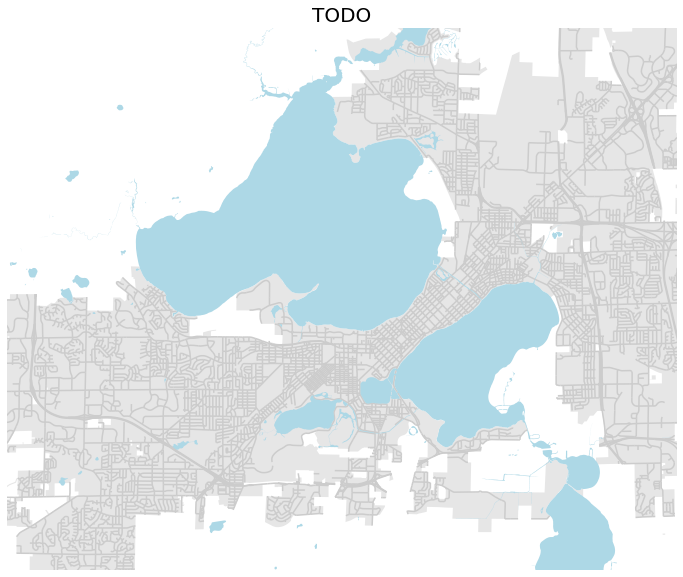

In [11]:
fig, ax = plt.subplots(figsize = (12,10))
madison.plot(ax=ax, color='0.9', zorder=0.7)
streets.plot(ax=ax, color='0.8', zorder=0.8)
lakes.plot(ax=ax, color='lightblue')
fig.patch.set_visible(False)
ax.axis('off')
plt.gca().set_title('TODO', fontsize=20)
ax.margins(x=-0.12, y=-0.12)

In [12]:

def plot_boxes():
    lats = get_lat_boundaries()
    lons = get_lon_boundaries()
    boxes = []
    for j in range(len(get_lat_boundaries())-1):
        for i in range(len(get_lon_boundaries())-1):
            rect = box(lons[i], lats[j], lons[i+1], lats[j+1]) #lon1, lat1, lon2, lat2
            boxes.append(rect)
    
    for geom in boxes:
        for stop in riders.geometry.to_list():
            if geom.contains(stop):     
                x, y = geom.exterior.xy
                ax.fill(x, y, fc='pink', ec='red', zorder=1)
                continue
                
def plot_boxes_ridership():
    lats = get_lat_boundaries()
    lons = get_lon_boundaries()
    boxes = []
    for j in range(len(get_lat_boundaries())-1):
        for i in range(len(get_lon_boundaries())-1):
            rect = box(lons[i], lats[j], lons[i+1], lats[j+1]) #lon1, lat1, lon2, lat2
            boxes.append(rect)
            
    dailyriders = []
    key_boxes = []
    for geom in boxes:
        for stop in riders.geometry.to_list():
            if geom.contains(stop):    
                key_boxes.append(geom)
                break
                
                
    for geom in key_boxes:
        seen = set()
        riders_in_geom = 0
        for idx, row in riders.iterrows():
            if row.stop_id not in seen:
                if geom.contains(row.geometry):
                    seen.add(row.stop_id)
                    riders_in_geom += row.ridership
        dailyriders.append(riders_in_geom)
#         x, y = geom.exterior.xy
#         ax.fill(x, y, fc=str(, ec='red', zorder=1)
    df_setup = {'geometry':key_boxes, 'Ridership':dailyriders }
    return pd.DataFrame.from_dict(df_setup)
data = plot_boxes_ridership()

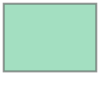

In [13]:
data.geometry[0]

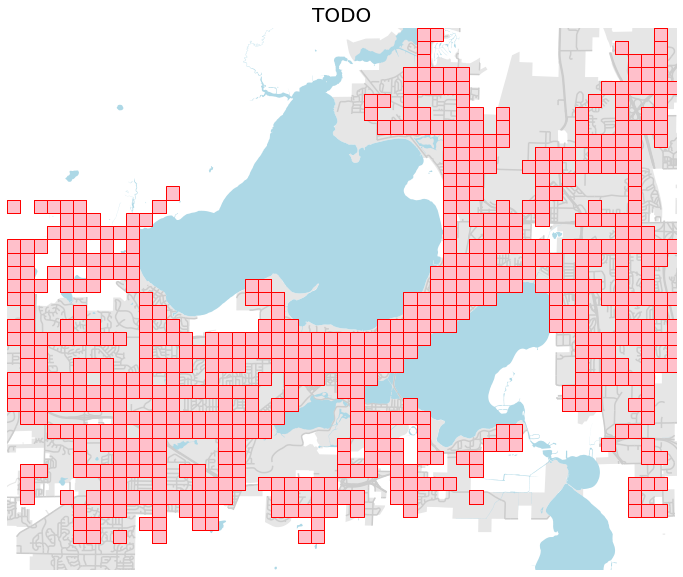

In [14]:
fig, ax = plt.subplots(figsize = (12,10))

# bus_stops.plot(ax=ax, color='0', zorder=5, markersize=10, marker='x')
madison.plot(ax=ax, color='0.9', zorder=0.7)
streets.plot(ax=ax, color='0.8', zorder=0.8)
lakes.plot(ax=ax, color='lightblue')
fig.patch.set_visible(False)
ax.axis('off')
plt.gca().set_title('TODO', fontsize=20)
ax.margins(x=-0.12, y=-0.12)
plot_boxes()

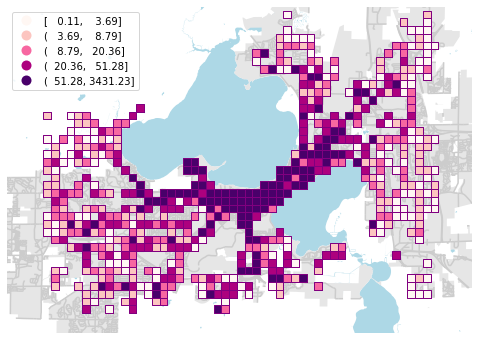

In [27]:
fig, ax = plt.subplots(figsize = (11,6))
gdf = geopandas.GeoDataFrame(data)
gdf = gdf[gdf.Ridership != 0]
gdf.plot(ax=ax, column=gdf.Ridership,cmap='RdPu', scheme='quantiles', edgecolor='purple',zorder=0.95, legend=True,legend_kwds={'loc': 'upper left'})
madison.plot(ax=ax, color='0.9', zorder=0.7)
streets.plot(ax=ax, color='0.8', zorder=0.8)
lakes.plot(ax=ax, color='lightblue', zorder=0.6)
fig.patch.set_visible(False)
ax.axis('off')
ax.margins(x=-0.05, y=-0.11)
# ax.set_title('Ridership Values in Madison', fontsize=20)
fig.savefig('RidershipMadison.png', dpi=200)

# Num of Squares in One Trip Analysis

In [16]:
def build_access():
    lats = get_lat_boundaries()
    lons = get_lon_boundaries()
    boxes = []
    for j in range(len(get_lat_boundaries())-1):
        for i in range(len(get_lon_boundaries())-1):
            rect = box(lons[i], lats[j], lons[i+1], lats[j+1]) #lon1, lat1, lon2, lat2
            boxes.append(rect)
            
    key_boxes = []
    for geom in boxes:
        for stop in riders.geometry.to_list():
            if geom.contains(stop):    
                key_boxes.append(geom)
                break
    #building dataframe row by row
    df = pd.DataFrame(columns=['geometry', 'stops'])

    seen = set()
    i = 0
    for geom in key_boxes:
        geomstop = [geom, []]
        for idx, row in riders.iterrows():
            if row['stop_id'] not in seen:
                if geom.contains(row['geometry']):
                    seen.add(row['stop_id'])
                    geomstop[1].append(row.stop_id)
                
                
        df.loc[i] = geomstop
        i += 1
            
    return df

df1 = build_access()
df1

,geometry,stops
0,POLYGON ((-89.51056717830025 43.01679492832921...,"[8153, 8192]"
1,POLYGON ((-89.50561556571141 43.01679492832921...,"[8351, 8405, 8679, 8830, 8934]"
2,POLYGON ((-89.50066395312257 43.01679492832921...,"[8461, 8739]"
3,POLYGON ((-89.49571234053373 43.01679492832921...,"[8259, 8388, 8592, 8849]"
4,POLYGON ((-89.49076072794489 43.01679492832921...,"[8230, 8617]"
...,...,...
673,"POLYGON ((-89.2827929992136 43.15800672060747,...","[9196, 9327, 9684]"
674,POLYGON ((-89.26298654885824 43.15800672060747...,"[9543, 9862]"
675,POLYGON ((-89.27784138662476 43.16162753579409...,"[9580, 9741]"
676,"POLYGON ((-89.2580349362694 43.16162753579409,...","[9177, 9490]"


In [17]:
def build_route_list():
    final = []
    for idx, row in df1.iterrows():
        temp = []
        for route in route_stops:
            for stop in row['stops']:
                if stop in route_stops[route]:
                    temp.append(route)
                    break
        if len(temp) == 0:
            temp = 0
        final.append(temp)
    return final

route_s = build_route_list()

In [18]:
df1['route'] = route_s
df1 = df1[df1.route != 0]
df1.head()

,geometry,stops,route
1,POLYGON ((-89.50561556571141 43.01679492832921...,"[8351, 8405, 8679, 8830, 8934]",[51]
2,POLYGON ((-89.50066395312257 43.01679492832921...,"[8461, 8739]",[51]
5,POLYGON ((-89.47590589017837 43.01679492832921...,[4984],[52]
6,POLYGON ((-89.47095427758953 43.01679492832921...,"[4541, 4836, 4993]",[52]
7,POLYGON ((-89.41648653911228 43.01679492832921...,"[4699, 4707, 4894]","[40, 49, 75]"


In [19]:
def match():
    final = []
    for idx1, row1 in df1.iterrows():
        count = 0
        for route in row1.route:
            for idx2, row2 in df1.iterrows():
                if route in row2['route']:
                    count += 1
        
        final.append(count)
        
    return final
                
counts = match()    

In [20]:
df1['num_box'] = counts
df1.sort_values(by='num_box', ascending=False)

<ipython-input-20-2cb271df515f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['num_box'] = counts


,geometry,stops,route,num_box
321,POLYGON ((-89.39668008875692 43.07110715612854...,"[39, 68, 70, 100, 180, 341, 435, 455, 538, 670...","[2, 4, 6, 7, 8, 10, 11, 12, 13, 15, 27, 48, 70...",627
320,POLYGON ((-89.40163170134576 43.07110715612854...,"[104, 234, 256, 441, 490, 581, 706, 741, 757, ...","[2, 4, 7, 8, 10, 11, 12, 13, 15, 27, 44, 48, 7...",557
362,POLYGON ((-89.38677686357924 43.07472797131516...,"[96, 252, 480, 567, 803, 883, 898, 918, 1558]","[2, 4, 6, 7, 8, 10, 12, 15, 27, 70, 72, 81]",513
363,"POLYGON ((-89.3818252509904 43.07472797131516,...","[597, 1100, 1310, 1495, 1618, 1787]","[2, 4, 5, 6, 7, 8, 12, 15, 23, 27, 70, 72, 75]",513
324,"POLYGON ((-89.3818252509904 43.07110715612854,...","[248, 1101, 1163, 1324, 1790, 1823, 1872]","[2, 4, 5, 6, 7, 8, 12, 15, 23, 27, 70, 72, 75]",513
...,...,...,...,...
572,POLYGON ((-89.34221235027968 43.11093612318138...,[9837],[17],7
571,POLYGON ((-89.34716396286852 43.11093612318138...,[9274],[17],7
615,POLYGON ((-89.29269622439128 43.12904019911449...,"[9140, 9310]",[36],6
605,POLYGON ((-89.29269622439128 43.12541938392787...,[9620],[36],6


In [21]:
gdf = geopandas.GeoDataFrame(df1, geometry = df1.geometry)

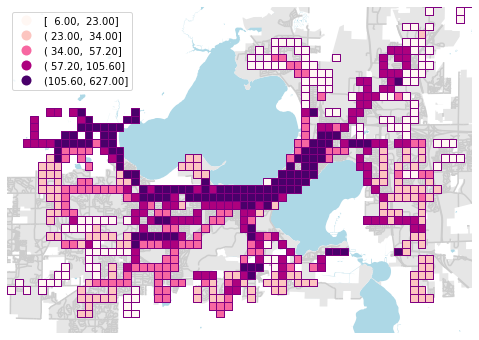

In [24]:
fig, ax = plt.subplots(figsize = (11,6))
gdf.plot(ax=ax, column=gdf['num_box'],cmap='RdPu', scheme='quantiles', edgecolor='purple',zorder=0.95, legend=True,legend_kwds={'loc': 'upper left'})
madison.plot(ax=ax, color='0.9', zorder=0.7)
streets.plot(ax=ax, color='0.8', zorder=0.8)
lakes.plot(ax=ax, color='lightblue', zorder=0.6)
fig.patch.set_visible(False)
ax.axis('off')
ax.margins(x=-0.05, y=-0.11)
# ax.set_title('Regions Accessed With No Transfers', fontsize=20)
fig.savefig('NumOfRegionsAccessed.png', dpi=200)